In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from typing import List
from matplotlib.colors import LogNorm
import matplotlib.colors as colors
import matplotlib.patches as patches
# Global Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {DEVICE}")

BATCH_SIZE = 2048
TRAIN_STEPS = 10000      
LR = 1e-3
HIDDENS = [64, 64, 64, 64] 
GRID_SIZE = 4            
DATA_SCALE = 4.0        
TRUNC_LIMIT = 4.0 
NORMAL_STD = 2
# visualization
PLOT_SCALE = 5.0         

Running on: cuda


In [2]:
class CheckerboardSampleable:
    def __init__(self, device, grid_size=4, scale=4.0):
        self.grid_size = grid_size
        self.scale = scale
        self.device = device
        
    def sample(self, num_samples):
        grid_length = 2 * self.scale / self.grid_size
        samples = torch.zeros(0, 2).to(self.device)
        
        while samples.shape[0] < num_samples:
            needed = num_samples - samples.shape[0]
            candidates = (torch.rand(needed * 4, 2).to(self.device) - 0.5) * 2 * self.scale
            
            x_idx = torch.floor((candidates[:,0] + self.scale) / grid_length)
            y_idx = torch.floor((candidates[:,1] + self.scale) / grid_length)
            
            # XOR Pattern
            mask = (x_idx % 2) != (y_idx % 2) 
            accepted = candidates[mask]
            samples = torch.cat([samples, accepted], dim=0)
            
        return samples[:num_samples]

#MLP
class MLPVectorField(nn.Module):
    def __init__(self, dim: int, hiddens: List[int]):
        super().__init__()
        layers = []
        # Input: dim + 1 (time)
        all_dims = [dim + 1] + hiddens + [dim]
        
        for i in range(len(all_dims) - 1):
            layers.append(nn.Linear(all_dims[i], all_dims[i+1]))
            # Lab 使用 SiLU
            if i < len(all_dims) - 2:
                layers.append(nn.SiLU())
                
        self.net = nn.Sequential(*layers)

    def forward(self, x, t):
        xt = torch.cat([x, t], dim=-1)
        return self.net(xt)

In [3]:
#solver 
def solve_ode(model, x0, steps=100):
    """Euler Solver"""
    x = x0.clone()
    dt = 1.0 / steps
    t_grid = torch.linspace(0, 1, steps+1).to(DEVICE)
    
    model.eval()
    with torch.no_grad():
        for i in range(steps):
            t_val = t_grid[i].item()
            t = torch.full((x.shape[0], 1), t_val).to(DEVICE)
            v = model(x, t)
            x = x + v * dt
    return x
#fix max(for visualization)
def hist2d_fixed(samples, ax, title, scale, vmax=None):
    H, xedges, yedges = np.histogram2d(
        samples[:, 0], samples[:, 1], 
        bins=300, 
        range=[[-scale, scale], [-scale, scale]]
    )
    H = H.T
    H[H < 1] = 1 
    if vmax is None:
        vmax = H.max()
    ax.imshow(
        H, 
        extent=[-scale, scale, -scale, scale], 
        origin='lower', 
        cmap='viridis', 
        interpolation='nearest',
        norm=colors.LogNorm(vmin=1, vmax=vmax) 
    )
    
    ax.set_title(title, fontsize=12, pad=10)
    ax.set_xlim(-scale, scale)
    ax.set_ylim(-scale, scale)
    ax.set_xticks([])
    ax.set_yticks([])
    return H.max() 

In [4]:
# Training Two Models
#Model 1: Baseline 
print(">>> Training Baseline Model (Standard Gaussian)...")
model_baseline = MLPVectorField(dim=2, hiddens=HIDDENS).to(DEVICE)
opt_baseline = torch.optim.Adam(model_baseline.parameters(), lr=LR)

target_dist = CheckerboardSampleable(DEVICE, grid_size=GRID_SIZE, scale=DATA_SCALE)

for step in range(TRAIN_STEPS):
    opt_baseline.zero_grad()
    
    # Baseline: x0 ~ N(0, 1)
    x0 = torch.randn(BATCH_SIZE, 2).to(DEVICE) *NORMAL_STD
    x1 = target_dist.sample(BATCH_SIZE)
    t = torch.rand(BATCH_SIZE, 1).to(DEVICE)
    
    xt = (1 - t) * x0 + t * x1
    ut_target = x1 - x0
    
    vt = model_baseline(xt, t)
    loss = torch.mean((vt - ut_target)**2)
    loss.backward()
    opt_baseline.step()
    
    if step % 1000 == 0:
        print(f"Baseline Step {step} | Loss: {loss.item():.4f}")


# Model 2: Our Metho
print("\n>>> Training Our Method (Support Alignment)...")
model_method = MLPVectorField(dim=2, hiddens=HIDDENS).to(DEVICE)
opt_method = torch.optim.Adam(model_method.parameters(), lr=LR)

for step in range(TRAIN_STEPS):
    opt_method.zero_grad()
    # epsilon ~ N(0, 1)
    epsilon = torch.randn(BATCH_SIZE, 2).to(DEVICE) *NORMAL_STD
    # torch.clamp
    x0 = torch.clamp(epsilon, min=-TRUNC_LIMIT, max=TRUNC_LIMIT)
    
    x1 = target_dist.sample(BATCH_SIZE)
    t = torch.rand(BATCH_SIZE, 1).to(DEVICE)
    
    xt = (1 - t) * x0 + t * x1
    ut_target = x1 - x0
    
    vt = model_method(xt, t)
    loss = torch.mean((vt - ut_target)**2)
    loss.backward()
    opt_method.step()
    
    if step % 1000 == 0:
        print(f"Our Method Step {step} | Loss: {loss.item():.4f}")

print("All Training Complete.")

>>> Training Baseline Model (Standard Gaussian)...
Baseline Step 0 | Loss: 9.6370
Baseline Step 1000 | Loss: 7.0288
Baseline Step 2000 | Loss: 6.8145
Baseline Step 3000 | Loss: 6.7299
Baseline Step 4000 | Loss: 7.0087
Baseline Step 5000 | Loss: 6.9574
Baseline Step 6000 | Loss: 6.7633
Baseline Step 7000 | Loss: 6.9502
Baseline Step 8000 | Loss: 6.8854
Baseline Step 9000 | Loss: 6.6325

>>> Training Our Method (Support Alignment)...
Our Method Step 0 | Loss: 9.0354
Our Method Step 1000 | Loss: 6.7624
Our Method Step 2000 | Loss: 6.6596
Our Method Step 3000 | Loss: 6.5492
Our Method Step 4000 | Loss: 6.6457
Our Method Step 5000 | Loss: 6.7247
Our Method Step 6000 | Loss: 6.5860
Our Method Step 7000 | Loss: 6.6323
Our Method Step 8000 | Loss: 6.6536
Our Method Step 9000 | Loss: 6.5438
All Training Complete.


In [5]:
#inference 
NUM_EVAL = 1000000    #sample    
STRESS_LEVELS = [1, 1.5, 2]  # std = 2.0, 3.0, 4.0

# visual config
BOX_COLOR = 'white'       
BRIGHTNESS_FACTOR = 150.0  
PLOT_SCALE = 5.0          
tolerance = 1.02 
print(f"Running Inference for 2x3 Grid (Levels: {STRESS_LEVELS})...")

results = {
    'No Clip': {},
    'Clip': {}
}


for level in STRESS_LEVELS:
    current_std = NORMAL_STD     * level
    print(f"  Processing Stress Level: {level}x (std={current_std})")
    
    # noise
    x0_raw = torch.randn(NUM_EVAL, 2).to(DEVICE) * current_std
    
    # Row 2: No Clip
    results['No Clip'][level] = solve_ode(model_baseline  , x0_raw)
    
    # Row 1: Clip 
    x0_clipped = torch.clamp(x0_raw, min=-TRUNC_LIMIT, max=TRUNC_LIMIT)
    results['Clip'][level] = solve_ode(model_method, x0_clipped)

print("Inference Done.")

Running Inference for 2x3 Grid (Levels: [1, 1.5, 2])...
  Processing Stress Level: 1x (std=2)
  Processing Stress Level: 1.5x (std=3.0)
  Processing Stress Level: 2x (std=4)
Inference Done.


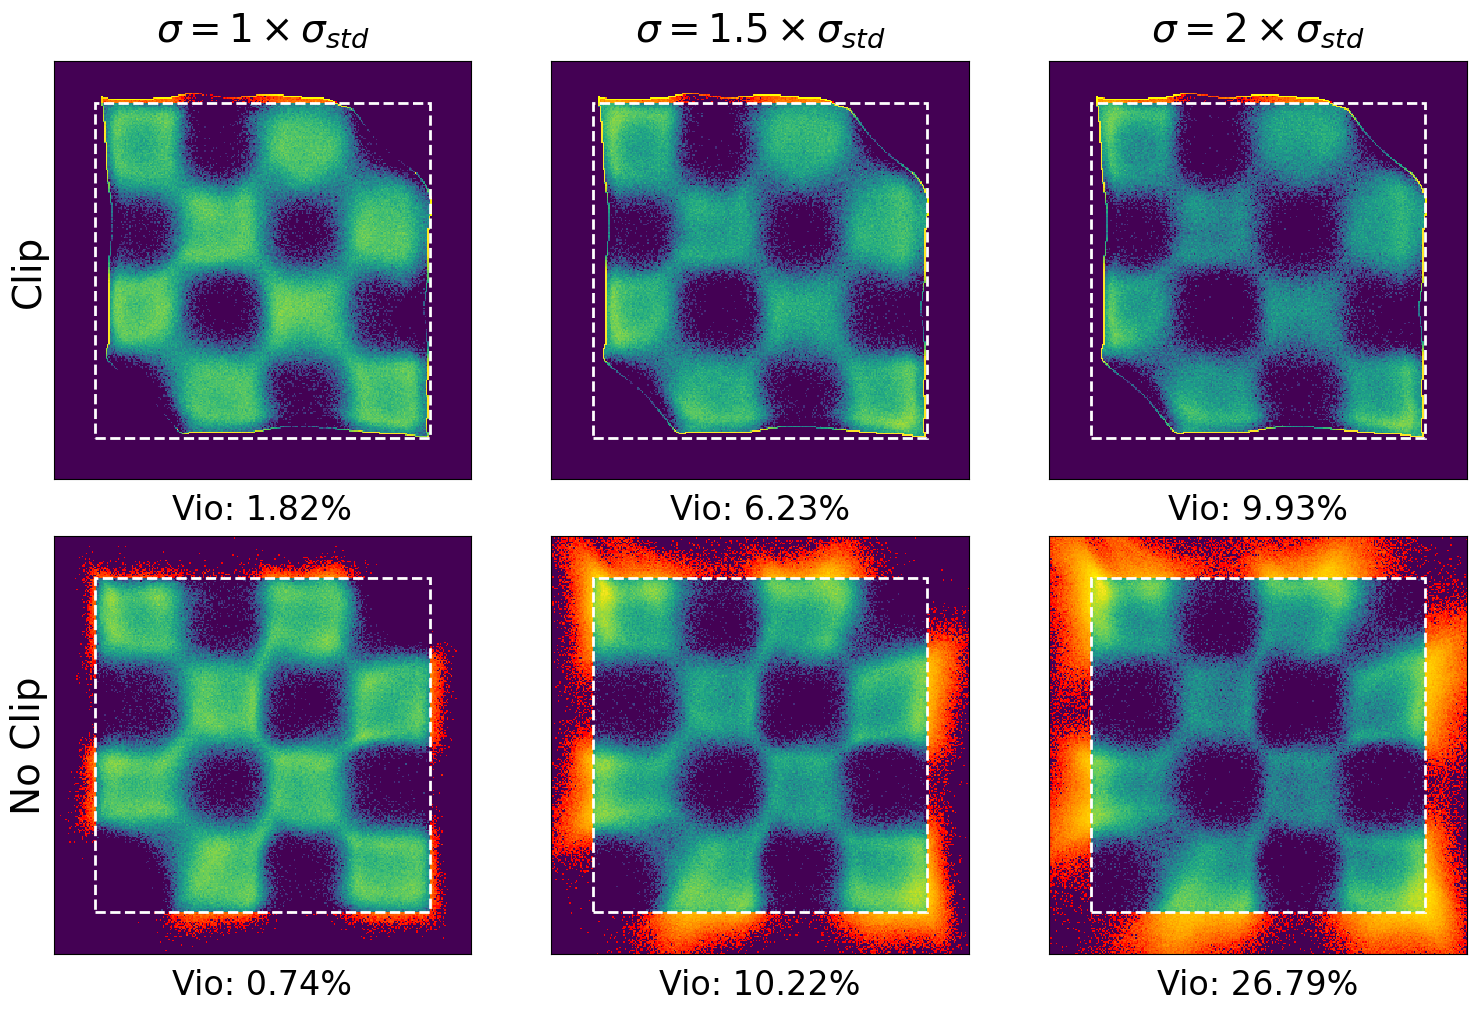

In [6]:
#visualization
def calc_violation(samples, limit):
    is_violated = (torch.abs(samples) > limit * tolerance).any(dim=1).float()
    return is_violated.mean().item() * 100

def get_max_density(samples):
    H, _, _ = np.histogram2d(samples[:,0], samples[:,1], bins=300, 
                             range=[[-PLOT_SCALE, PLOT_SCALE], [-PLOT_SCALE, PLOT_SCALE]])
    return H.max()

all_samples = []
for m in results:
    for l in results[m]:
        all_samples.append(results[m][l].cpu().numpy())

global_max = max([get_max_density(s) for s in all_samples])
VMAX_FINAL = global_max / BRIGHTNESS_FACTOR 

def hist2d_dual_color(samples, ax, title, vmax, limit):
    H, xedges, yedges = np.histogram2d(
        samples[:, 0], samples[:, 1], bins=300, 
        range=[[-PLOT_SCALE, PLOT_SCALE], [-PLOT_SCALE, PLOT_SCALE]]
    )
    H = H.T
    x_centers = (xedges[:-1] + xedges[1:]) / 2
    y_centers = (yedges[:-1] + yedges[1:]) / 2
    X, Y = np.meshgrid(x_centers, y_centers)
    
    out_mask = (np.abs(X) > limit) | (np.abs(Y) > limit)
    
    norm = colors.LogNorm(vmin=1, vmax=vmax)
    H_safe = H.copy(); H_safe[H < 1] = 1
    
    rgba_img = plt.cm.viridis(norm(H_safe))
    warn_img = plt.cm.autumn(norm(H_safe))
    
    has_points = (H >= 1)
    violation_pixels = out_mask & has_points
    rgba_img[violation_pixels] = warn_img[violation_pixels]
    
    ax.imshow(rgba_img, extent=[-PLOT_SCALE, PLOT_SCALE, -PLOT_SCALE, PLOT_SCALE], 
              origin='lower', interpolation='nearest')
    
    ax.set_title(title, fontsize=20, pad=8)
    ax.set_xlim(-PLOT_SCALE, PLOT_SCALE)
    ax.set_ylim(-PLOT_SCALE, PLOT_SCALE)
    ax.set_xticks([])
    ax.set_yticks([])

def add_box(ax, limit, color):
    rect = patches.Rectangle((-limit, -limit), 2*limit, 2*limit, 
                             linewidth=2, edgecolor=color, facecolor='none', linestyle='--')
    ax.add_patch(rect)


# 2 Row x 3 Col
fig, axes = plt.subplots(2, 3, figsize=(15, 10), constrained_layout=True)

rows = ["Clip", "No Clip"] # 上 Clip, 下 No Clip
cols_latex = [fr"$\sigma = {level} \times \sigma_{{std}}$" for level in STRESS_LEVELS]

modes = ['Clip', 'No Clip'] # 对应 Row 0, Row 1

for row_idx, mode in enumerate(modes):
    for col_idx, level in enumerate(STRESS_LEVELS):
        ax = axes[row_idx, col_idx]
        data = results[mode][level].cpu().numpy()
        
        # violation
        vio = calc_violation(torch.tensor(data), TRUNC_LIMIT)
        
        hist2d_dual_color(data, ax, "", VMAX_FINAL, TRUNC_LIMIT)
        add_box(ax, TRUNC_LIMIT, BOX_COLOR)
        

        if row_idx == 0:
            ax.set_title(cols_latex[col_idx], fontsize=28, pad=15)
            
        ax.set_xlabel(f"Vio: {vio:.2f}%", fontsize=24, labelpad=10)
        
        # Label
        if col_idx == 0:
            ax.set_ylabel(rows[row_idx], fontsize=28)

plt.savefig('checkerboard_stress_2x3.png', dpi=300)
plt.show()